# DeepLearning 25Spring Project_1

## Group member: Zhuoao Wang, Yutian Luo, Yuqi Wang.

## Based on ResNet18

### 1. Improt packages & Manage parameters & Set random seed

In [9]:
import os
import random
import pickle
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm  
import matplotlib.pyplot as plt 

config = {
    "seed": 42,
    "batch_size": 64,
    "lr": 0.002,
    "weight_decay": 5e-4,
    "label_smoothing": 0.1,
    "max_epochs": 30,
    "dropout_p": 0.3,
    "num_classes": 10,
    "data_root": "./data",
    "ckpt_path": "output/smaller_resnet_final.pth",
    "pkl_file": "input/cifar_test_nolabel.pkl",
    "submission_csv": "output/submission.csv",
    "num_workers": 2
}

def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seed(config["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use:", device)

Use: cuda


### 2. Set Squeeze and Excitation Block (Improve CNN)

In [10]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.SiLU(),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = self.global_avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        return x * y.expand_as(x)

### 3. Improve ResBlock (Two convolutions, using SiLU as the activation function, GroupNorm.)

In [11]:
class ImprovedResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_se=True):
        super(ImprovedResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1   = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2   = nn.GroupNorm(8, out_channels)
        self.silu  = nn.SiLU()
        self.se    = SEBlock(out_channels) if use_se else nn.Identity()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride,
                          bias=False),
                nn.GroupNorm(8, out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += identity
        return self.silu(out)

### 4. Building the ResNet (Simplified Version: 4 stages)

In [12]:
class SmallerResNet(nn.Module):
    def __init__(self, num_classes=10, dropout_p=0.3):
        super(SmallerResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.GroupNorm(8, 32)
        self.silu  = nn.SiLU()

        self.layer1 = self._make_layer(ImprovedResBlock, 32, 32, 2, stride=1)
        self.layer2 = self._make_layer(ImprovedResBlock, 32, 64, 2, stride=2)
        self.layer3 = self._make_layer(ImprovedResBlock, 64, 128, 2, stride=2)
        self.layer4 = self._make_layer(ImprovedResBlock, 128, 256, 2, stride=2)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, block, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride=stride))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.silu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

### 5. Load Data & Data Aug

In [13]:
def get_dataloaders(config):
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=config["data_root"],
        train=True,
        download=True,
        transform=train_transform
    )
    trainloader = DataLoader(trainset,
                             batch_size=config["batch_size"],
                             shuffle=True,
                             num_workers=config["num_workers"])

    testset = torchvision.datasets.CIFAR10(
        root=config["data_root"],
        train=False,
        download=True,
        transform=test_transform
    )
    testloader = DataLoader(testset,
                            batch_size=config["batch_size"],
                            shuffle=False,
                            num_workers=config["num_workers"])

    return trainloader, testloader

### 6. Train

In [14]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch_idx, max_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch_idx}/{max_epochs}", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        current_loss = running_loss / total
        current_acc  = correct / total
        pbar.set_postfix({
            "loss": f"{current_loss:.4f}",
            "acc":  f"{current_acc:.4f}"
        })

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


def evaluate_on_testset(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


def train_model(model, trainloader, testloader, config, device):
    criterion = nn.CrossEntropyLoss(label_smoothing=config["label_smoothing"])
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )
    scheduler = lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=config["max_epochs"]
    )

    train_losses = []
    train_accs   = []
    test_accs    = []

    for epoch in range(config["max_epochs"]):
        train_loss, train_acc = train_one_epoch(
            model=model,
            dataloader=trainloader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            epoch_idx=epoch + 1,
            max_epochs=config["max_epochs"]
        )

        scheduler.step()
        test_acc = evaluate_on_testset(model, testloader, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"[Epoch {epoch+1}/{config['max_epochs']}] "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, "
              f"Test Acc: {test_acc:.4f}")

    torch.save(model.state_dict(), config["ckpt_path"])
    print(f"Training finished. Model saved as {config['ckpt_path']}")

    plt.figure()
    plt.title("Training Loss")
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("output/Train loss.png")
    plt.show()

    plt.figure()
    plt.title("Accuracy")
    plt.plot(train_accs, label="Train Acc")
    plt.plot(test_accs, label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig("output/Acc.png")
    plt.show()

### 7. Predict from .pkl

In [15]:
def predict_from_pkl(model, pkl_file, device, out_csv="submission.csv", batch_size=64):
    with open(pkl_file, "rb") as f:
        data_dict = pickle.load(f)
    
    image_data = data_dict[b'data'] 
    image_ids  = data_dict[b'ids']

    if isinstance(image_data, np.ndarray):
        image_data = torch.tensor(image_data).float()
    if image_data.max() > 1:
        image_data = image_data / 255.0
    if image_data.shape[-1] == 3:
        image_data = image_data.permute(0, 3, 1, 2)

    image_data = (image_data - 0.5) / 0.5

    model.eval()
    predictions_list = []
    with torch.no_grad():
        for i in range(0, image_data.size(0), batch_size):
            batch = image_data[i : i + batch_size].to(device)
            outputs = model(batch)
            _, preds = torch.max(outputs, 1)
            predictions_list.append(preds.cpu())

    predictions_all = torch.cat(predictions_list, dim=0)
    df = pd.DataFrame({"ID": image_ids, "Label": predictions_all.tolist()})
    df.to_csv(out_csv, index=False)
    print(f"Prediction finished! Output -> {out_csv}")
    
def load_model_and_predict_pkl(config):
    model_best = SmallerResNet(num_classes=config["num_classes"], dropout_p=config["dropout_p"]).to(device)
    if os.path.exists(config["ckpt_path"]):
        state_dict = torch.load(config["ckpt_path"], map_location=device, weights_only=True)
        model_best.load_state_dict(state_dict)
        print("Model weights loaded. Start inference...")
        predict_from_pkl(
            model_best,
            pkl_file=config["pkl_file"],
            device=device,
            out_csv=config["submission_csv"],
            batch_size=config["batch_size"]
        )
    else:
        print(f"Not found: {config['ckpt_path']}. Please train the model first.")

### 8. Main()

Files already downloaded and verified
Files already downloaded and verified
Model created.
Total parameters: 2820390 (~2.82M)


Epoch 1/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 1/30] Train Loss: 2.0013, Train Acc: 0.2905, Test Acc: 0.4554


Epoch 2/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 2/30] Train Loss: 1.6187, Train Acc: 0.4845, Test Acc: 0.6243


Epoch 3/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 3/30] Train Loss: 1.3743, Train Acc: 0.6057, Test Acc: 0.7257


Epoch 4/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 4/30] Train Loss: 1.2192, Train Acc: 0.6807, Test Acc: 0.7626


Epoch 5/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 5/30] Train Loss: 1.1270, Train Acc: 0.7236, Test Acc: 0.7833


Epoch 6/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 6/30] Train Loss: 1.0646, Train Acc: 0.7536, Test Acc: 0.7970


Epoch 7/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 7/30] Train Loss: 1.0074, Train Acc: 0.7792, Test Acc: 0.8127


Epoch 8/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 8/30] Train Loss: 0.9705, Train Acc: 0.7959, Test Acc: 0.8280


Epoch 9/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 9/30] Train Loss: 0.9356, Train Acc: 0.8120, Test Acc: 0.8334


Epoch 10/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 10/30] Train Loss: 0.9034, Train Acc: 0.8284, Test Acc: 0.8410


Epoch 11/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 11/30] Train Loss: 0.8767, Train Acc: 0.8395, Test Acc: 0.8511


Epoch 12/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 12/30] Train Loss: 0.8479, Train Acc: 0.8519, Test Acc: 0.8464


Epoch 13/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 13/30] Train Loss: 0.8259, Train Acc: 0.8622, Test Acc: 0.8512


Epoch 14/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 14/30] Train Loss: 0.8054, Train Acc: 0.8705, Test Acc: 0.8586


Epoch 15/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 15/30] Train Loss: 0.7805, Train Acc: 0.8806, Test Acc: 0.8603


Epoch 16/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 16/30] Train Loss: 0.7624, Train Acc: 0.8914, Test Acc: 0.8640


Epoch 17/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 17/30] Train Loss: 0.7470, Train Acc: 0.8977, Test Acc: 0.8673


Epoch 18/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 18/30] Train Loss: 0.7344, Train Acc: 0.9040, Test Acc: 0.8696


Epoch 19/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 19/30] Train Loss: 0.7229, Train Acc: 0.9088, Test Acc: 0.8710


Epoch 20/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 20/30] Train Loss: 0.7077, Train Acc: 0.9144, Test Acc: 0.8771


Epoch 21/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 21/30] Train Loss: 0.6939, Train Acc: 0.9212, Test Acc: 0.8775


Epoch 22/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 22/30] Train Loss: 0.6860, Train Acc: 0.9239, Test Acc: 0.8789


Epoch 23/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 23/30] Train Loss: 0.6810, Train Acc: 0.9254, Test Acc: 0.8791


Epoch 24/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 24/30] Train Loss: 0.6714, Train Acc: 0.9314, Test Acc: 0.8795


Epoch 25/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 25/30] Train Loss: 0.6634, Train Acc: 0.9335, Test Acc: 0.8851


Epoch 26/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 26/30] Train Loss: 0.6548, Train Acc: 0.9384, Test Acc: 0.8833


Epoch 27/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 27/30] Train Loss: 0.6534, Train Acc: 0.9392, Test Acc: 0.8829


Epoch 28/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 28/30] Train Loss: 0.6506, Train Acc: 0.9405, Test Acc: 0.8839


Epoch 29/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 29/30] Train Loss: 0.6483, Train Acc: 0.9412, Test Acc: 0.8836


Epoch 30/30:   0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 30/30] Train Loss: 0.6513, Train Acc: 0.9399, Test Acc: 0.8833
Training finished. Model saved as output/smaller_resnet_final.pth


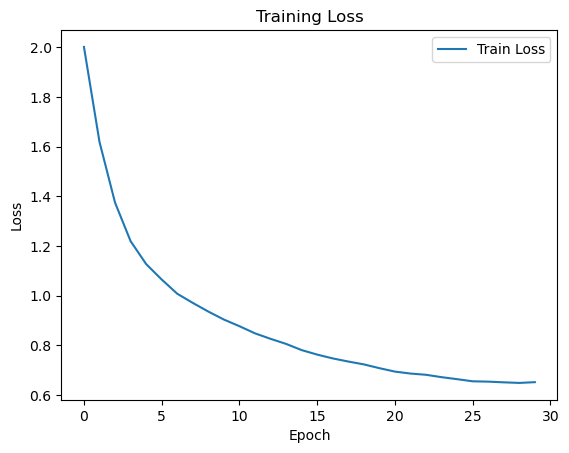

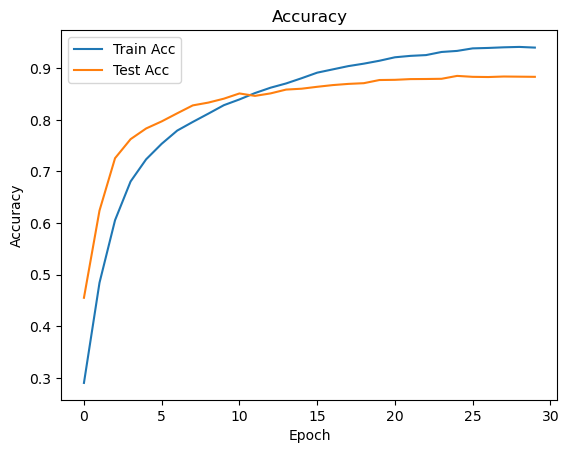

Model weights loaded. Start inference...
Prediction finished! Output -> output/submission.csv


In [16]:
if __name__ == "__main__":
    trainloader, testloader = get_dataloaders(config)

    os.makedirs("output", exist_ok=True)
    model = SmallerResNet(num_classes=config["num_classes"], dropout_p=config["dropout_p"]).to(device)

    print("Model created.")
    param_count = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {param_count} (~{param_count/1e6:.2f}M)")

    train_model(model, trainloader, testloader, config, device)

    load_model_and_predict_pkl(config)